<a href="https://colab.research.google.com/github/HwangHanJae/Dacon_competitions_cafeteria/blob/main/Dacon_cafetreria_prediction_top3_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Private 3위 수상자 코드 
[데이콘 링크](https://dacon.io/competitions/official/235743/codeshare/2983?page=1&dtype=recent)

수상자의 관점
1. 점심에 가는 사람도 저녁에도 갈 것이다.
2. 1번을 충족했을 시에 음식에 불호가 강하지 않으면 구내식당을 이용할 것이다.

2가지 관점으로 진행

#한글 폰트 패치

In [1]:
#나눔 고딕 폰트 인스톨
!apt-get update -qq
!apt-get install fonts-nanum* -qq

# 라이브러리 로드

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from IPython.display import set_matplotlib_formats
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
set_matplotlib_formats('svg')

#맷플롯립 폰트 관련 매니저
import matplotlib.font_manager as fm
# 맷플롯라이브러리에 폰트 설정
plt.rc('font', family='NanumBarunGothic') 
fm._rebuild()
# 진행후에 런타임 다시시작
print("현재 설정 폰트",plt.rcParams['font.family'])

현재 설정 폰트 ['NanumBarunGothic']


# 데이터 탐색 및 전처리

1. train_lunch, train_dinner
2. test_lunch, test_dinner
3. 전체 합쳐진 데이터
- 6개의 파일로 저장을 해둠

- 하나의 데이터로 해주면 되지만, 좀더 직관적으로 보기위하여 나누어줌
- test에 'none'값을 없애주면 다른 행들도 사라지기 때문에 따로 나누어서 저장해줌
- 나중에 학습할 때 'None' 값만 없애주고 학습을 하기위해 데이터들을 나누어줌

In [4]:
path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/cafeteria/"
df = pd.read_csv(path + 'train.csv')

df.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


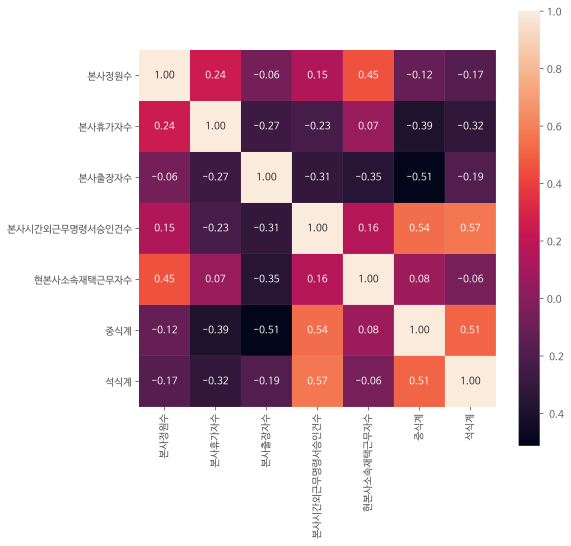

In [6]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', square=True)


- 중식계, 석식계가 상관관계(0.51)가 있다고 볼수 있음
- 점심에도 먹은 사람은 저녁에도 먹을 가능성이 크다고 생각함
- 점심때 밖에서 먹지 않은 사람들은 시간을 효율적으로 쓰고 음식에 대해 딱히 관심이 없을 수도 있음
- 이 사람들의 시간이 가장 중요하다고 생각
- 그럼에도 음식이 너무 맛이 없으면 밖에서 사먹을 수도 있음 - 두번째 가설
- 음식은 밥, 국, 메인반찬이 중요하므로 음식이 너무 맛이 없지 않는 한 구내식당을 이용할거라 예측

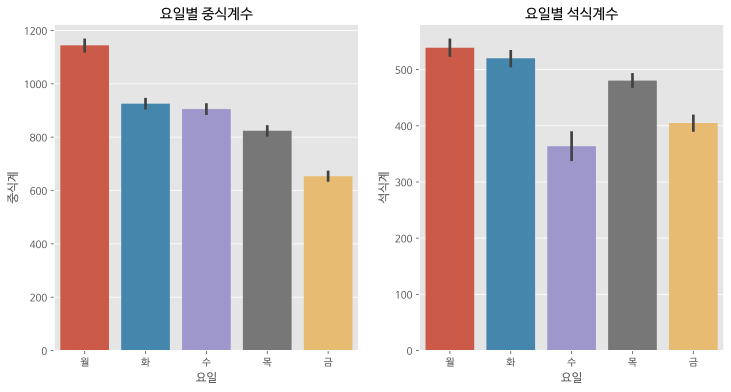

In [7]:
#요일별 중식계, 석식계 수
f, ax = plt.subplots(1,2,figsize=(12,6))

sns.barplot(x='요일', y='중식계', data=df, ax=ax[0])
ax[0].set_title("요일별 중식계수")
sns.barplot(x='요일', y='석식계', data=df, ax=ax[1])
ax[1].set_title("요일별 석식계수")
plt.show()

중식계 : 

- 월요일에 가장 많고 금요일로 갈수록 줄어들고 있음

석식계 :

- 수요일 금요일이 가장 적음

  - 수요일날 한번 쉬는 의미로 약속이 많을 수 있음
  - 금요일도 같은 맥락

  -> 월,화,목 은 열심히 , 수, 금은 휴식

  ※ 수요일에 자기개발의 날이 존재


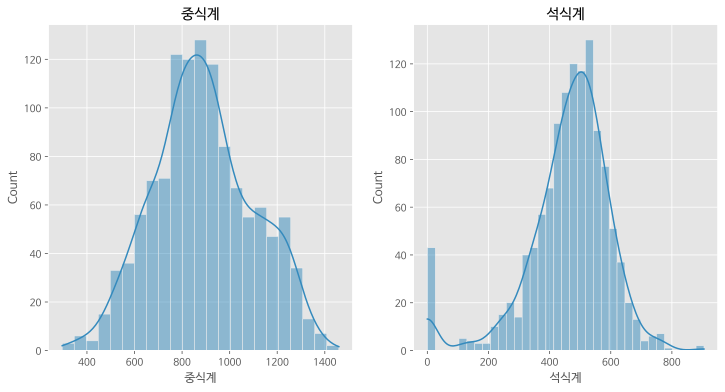

In [8]:
f, ax = plt.subplots(1,2,figsize=(12,6))
sns.histplot(data=df, x='중식계', kde=True,ax=ax[0])
ax[0].set_title("중식계")
sns.histplot(data=df, x='석식계', kde=True, ax=ax[1])
ax[1].set_title('석식계')
plt.show()

정규분포를 보이며, Min-Max scale을 이용해줄 필요가 없음

In [9]:
print("본사정원수(총인원) : ",df['본사정원수'].max())
print()
print("중식계 : ")
print(df['중식계'].describe())
print()
print("석식계 : ")
print(df['석식계'].describe())

본사정원수(총인원) :  3305

중식계 : 
count    1205.000000
mean      890.334440
std       209.505057
min       296.000000
25%       758.000000
50%       879.000000
75%      1032.000000
max      1459.000000
Name: 중식계, dtype: float64

석식계 : 
count    1205.000000
mean      461.772614
std       139.179202
min         0.000000
25%       406.000000
50%       483.000000
75%       545.000000
max       905.000000
Name: 석식계, dtype: float64


총인원 : 3305명

중식계 최대 인원 : 1459명

석식계 최대 인원 : 905명

# 데이터 정리

In [10]:
df.columns = ['date', 'day', 'numbers','dayoff','work','outsidework','workhome','break','lunch','dinner','lunch_t','dinner_t']
df.head()

,date,day,numbers,dayoff,work,outsidework,workhome,break,lunch,dinner,lunch_t,dinner_t
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


컬럼 명을 영어로 바꾸어 줌

## 날짜 정리

In [11]:
df['date'] = pd.to_datetime(df['date'])
df['year_month'] = df['date'].dt.strftime('%Y%m')
df['date'] = df['date'].dt.strftime("%m%d")
df['month'] = df['date'].str[0:2]
df['Date'] = df['date'].str[2:]

In [12]:
df = df.drop(['date','break'], axis=1)

df.head(2)

,day,numbers,dayoff,work,outsidework,workhome,lunch,dinner,lunch_t,dinner_t,year_month,month,Date
0,월,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,201602,02,01
1,화,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,201602,02,02


정리한 date컬럼과 break컬럼을 제거
- break 컬럼은 아침식사는 영향이 없을 것 같음

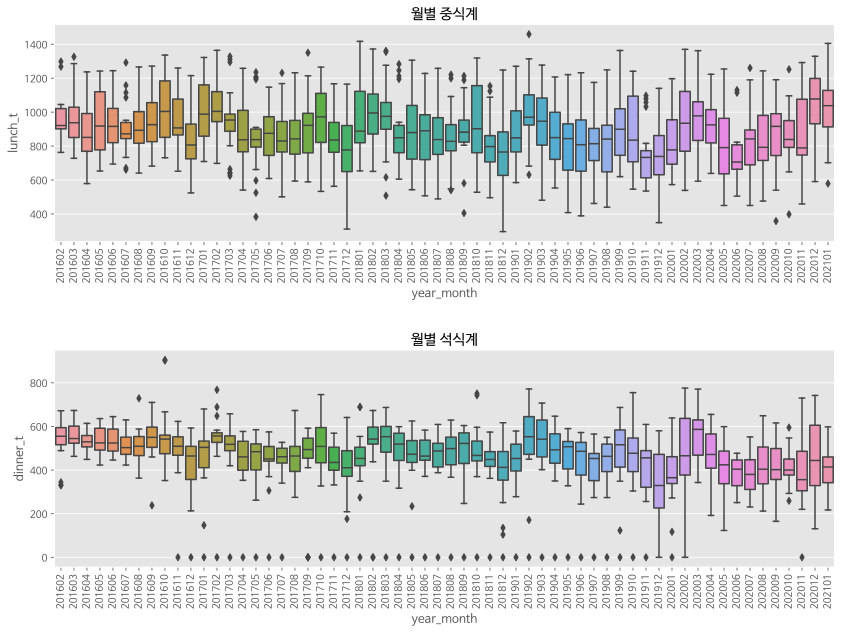

In [13]:
#월별 중식계, 석식계 사람수
f, ax = plt.subplots(2,1,figsize=(14,10))
f.subplots_adjust(hspace=0.5)
rot1 = sns.boxplot(data=df, x='year_month', y='lunch_t', ax=ax[0])
ax[0].set_title("월별 중식계")
rot2 = sns.boxplot(data=df, x='year_month', y='dinner_t', ax=ax[1])
ax[1].set_title("월별 석식계")
rots = [rot1, rot2]

for rot in rots:
  for item in rot.get_xticklabels():
    item.set_rotation(90)

plt.show()


중식계 : 
  
  - 12월에는 연말이어서 밖에서 사먹고오는 인원이 많아보임

석식계 :
  - 코로나로 인한 변화는 크게 보이지 않음.

In [14]:
df = df.drop(['year_month'], axis=1)

year_month 컬럼 삭제

## 메뉴 나누기

In [15]:
#일별 점심메뉴를 작은 리스트로 갖고 있는 큰 리스트 만들기
 
lunch_menu = []

for day in range(len(df)):
  tmp = df.loc[day, 'lunch'].split(' ') #스페이스바로 구분
  tmp = ' '.join(tmp).split() #빈칸 제거
   
  for menu in tmp:
    if "(" in menu:
      tmp.remove(menu)
  lunch_menu.append(tmp)

In [16]:
pd.DataFrame(lunch_menu).head() #데이터를 보기 쉽게 하기 위하여 데이터 프레임으로 표현

,0,1,2,3,4,5,6,7
0,쌀밥/잡곡밥,오징어찌개,쇠불고기,계란찜,청포묵무침,요구르트,포기김치,None
1,쌀밥/잡곡밥,김치찌개,가자미튀김,모둠소세지구이,마늘쫑무침,요구르트,배추겉절이,None
2,카레덮밥,팽이장국,치킨핑거,쫄면야채무침,견과류조림,요구르트,포기김치,None
3,쌀밥/잡곡밥,쇠고기무국,주꾸미볶음,부추전,시금치나물,요구르트,포기김치,None
4,쌀밥/잡곡밥,떡국,돈육씨앗강정,우엉잡채,청경채무침,요구르트,포기김치,None


In [17]:
for bob in range(len(df)):
  if "쌀밥" in  lunch_menu[bob][0]:
    lunch_menu[bob][0] = '밥'

In [18]:
lunch_menu[:3]

[['밥', '오징어찌개', '쇠불고기', '계란찜', '청포묵무침', '요구르트', '포기김치'],
 ['밥', '김치찌개', '가자미튀김', '모둠소세지구이', '마늘쫑무침', '요구르트', '배추겉절이'],
 ['카레덮밥', '팽이장국', '치킨핑거', '쫄면야채무침', '견과류조림', '요구르트', '포기김치']]

In [19]:
pd.DataFrame(lunch_menu).head(3)

,0,1,2,3,4,5,6,7
0,밥,오징어찌개,쇠불고기,계란찜,청포묵무침,요구르트,포기김치,None
1,밥,김치찌개,가자미튀김,모둠소세지구이,마늘쫑무침,요구르트,배추겉절이,None
2,카레덮밥,팽이장국,치킨핑거,쫄면야채무침,견과류조림,요구르트,포기김치,None


In [20]:
df['lunch_menu'] = lunch_menu
df.head()

,day,numbers,dayoff,work,outsidework,workhome,lunch,dinner,lunch_t,dinner_t,month,Date,lunch_menu
0,월,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,02,01,"[밥, 오징어찌개, 쇠불고기, 계란찜, 청포묵무침, 요구르트, 포기김치]"
1,화,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,02,02,"[밥, 김치찌개, 가자미튀김, 모둠소세지구이, 마늘쫑무침, 요구르트, 배추겉절이]"
2,수,2601,56,180,111,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,02,03,"[카레덮밥, 팽이장국, 치킨핑거, 쫄면야채무침, 견과류조림, 요구르트, 포기김치]"
3,목,2601,104,220,355,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,02,04,"[밥, 쇠고기무국, 주꾸미볶음, 부추전, 시금치나물, 요구르트, 포기김치]"
4,금,2601,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,02,05,"[밥, 떡국, 돈육씨앗강정, 우엉잡채, 청경채무침, 요구르트, 포기김치]"


In [21]:
# 메인, 국, 반찬 나누어주기
bob = []
soup = []
main = []

for i in range(len(df)):
  if lunch_menu[i][0]:
    bob.append(lunch_menu[i][0])
  if lunch_menu[i][1]:
    soup.append(lunch_menu[i][1])
  if lunch_menu[i][2]:
    main.append(lunch_menu[i][2])

#누락 확인
print("누락 확인")
print()
print(len(bob))
print(len(soup))
print(len(main))
print("----")
print(len(df))

누락 확인

1205
1205
1205
----
1205


In [22]:
df['bob'] = bob
df['soup'] = soup
df['main'] = main

df.head()

,day,numbers,dayoff,work,outsidework,workhome,lunch,dinner,lunch_t,dinner_t,month,Date,lunch_menu,bob,soup,main
0,월,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,02,01,"[밥, 오징어찌개, 쇠불고기, 계란찜, 청포묵무침, 요구르트, 포기김치]",밥,오징어찌개,쇠불고기
1,화,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,02,02,"[밥, 김치찌개, 가자미튀김, 모둠소세지구이, 마늘쫑무침, 요구르트, 배추겉절이]",밥,김치찌개,가자미튀김
2,수,2601,56,180,111,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,02,03,"[카레덮밥, 팽이장국, 치킨핑거, 쫄면야채무침, 견과류조림, 요구르트, 포기김치]",카레덮밥,팽이장국,치킨핑거
3,목,2601,104,220,355,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,02,04,"[밥, 쇠고기무국, 주꾸미볶음, 부추전, 시금치나물, 요구르트, 포기김치]",밥,쇠고기무국,주꾸미볶음
4,금,2601,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,02,05,"[밥, 떡국, 돈육씨앗강정, 우엉잡채, 청경채무침, 요구르트, 포기김치]",밥,떡국,돈육씨앗강정


In [23]:
df['bob'].value_counts()

밥              1003
콩나물밥             23
카레덮밥             18
나물비빔밥            15
곤드레밥*강된장         12
단호박영양밥           10
카레라이스             8
김치제육덮밥            8
곤드레밥*양념장          8
곤드레밥              8
비빔밥               8
짜장덮밥              6
낙지비빔밥             6
마파두부덮밥            5
콩나물밥*양념장          5
산채비빔밥             5
짜장밥               4
열무보리비빔밥           4
소불고기덮밥            3
열무비빔밥             3
봄나물비빔밥            3
곤드레밥*간장양념         2
참치회덮밥             2
콩나물밥*달래장          2
단호박카레라이스          2
<초복특식>            2
호박된장국             1
오곡밥               1
전주비빔밥             1
소고기콩나물밥*양념        1
불고기덮밥             1
김밥볶음밥             1
봄새싹비빔밥            1
김치볶음밥             1
야채볶음밥*짜장소스        1
고기듬뿍카레라이스         1
산채비빔밥*강된장         1
계란채소볶음밥           1
오므라이스             1
베이컨김치볶음밥          1
건강비빔밥*약고추장        1
낙지볶음밥             1
전주비빔밥*약고추장        1
닭살카레라이스           1
삼계탕               1
낙지비빔밥*계란후라이       1
파인애플볶음밥           1
김치볶음밥/계란          1
김치필라프             1
돈육버섯고추장덮밥         1


In [24]:
df['soup'].value_counts()

맑은국         46
콩나물국        44
된장찌개        37
어묵국         31
아욱국         28
            ..
들깨버섯탕        1
콩나물맑은국       1
돼지김치찌개       1
홍합살무국        1
쇠고기매운버섯국     1
Name: soup, Length: 272, dtype: int64

In [25]:
df['main'].value_counts()

오징어볶음         32
닭갈비           30
버섯불고기         29
훈제오리구이        27
돈육굴소스볶음       25
              ..
고등어구이*와사비장     1
수원왕갈비          1
양념파닭           1
가자미무조림         1
해물까스           1
Name: main, Length: 391, dtype: int64

In [26]:
df['soup'].value_counts()[:10]

맑은국      46
콩나물국     44
된장찌개     37
어묵국      31
아욱국      28
배추된장국    28
가쯔오장국    28
근대국      26
꽃게탕      25
순두부찌개    23
Name: soup, dtype: int64

In [27]:
df['main'].value_counts()[:10]

오징어볶음      32
닭갈비        30
버섯불고기      29
훈제오리구이     27
돈육굴소스볶음    25
짬뽕불고기      24
제육볶음       23
등갈비김치찜     21
언양식불고기     20
주꾸미볶음      19
Name: main, dtype: int64

## 저녁 바꾸기

In [36]:
dinner_menu = []
for day in range(len(df)):
  tmp = df.loc[day, 'dinner'].split(' ')
  tmp = ' '.join(tmp).split()
  for menu in tmp:
    if '(' in menu:
      tmp.remove(menu)
  dinner_menu.append(tmp)

In [37]:
df['dinner_menu'] = dinner_menu

In [38]:
len(df['dinner_menu'])

1205

In [39]:
dinner_menu[0:5]

[['쌀밥/잡곡밥', '육개장', '자반고등어구이', '두부조림', '건파래무침', '포기김치'],
 ['콩나물밥*양념장', '어묵국', '유산슬', '아삭고추무침', '바나나', '포기김치'],
 ['쌀밥/잡곡밥', '청국장찌개', '황태양념구이', '고기전', '새송이버섯볶음', '포기김치'],
 ['미니김밥*겨자장', '우동', '멕시칸샐러드', '군고구마', '무피클', '포기김치'],
 ['쌀밥/잡곡밥', '차돌박이찌개', '닭갈비', '감자소세지볶음', '콩나물무침', '포기김치']]

In [40]:
print(range(len(df)))
print(range(len(dinner_menu)))

range(0, 1205)
range(0, 1205)


In [89]:
bob_d = []
soup_d = []
main_d = []

def append_None():
  bob_d.append("None") #비어 있으면 그 날짜 자체가 없어질 수 있으므로 'None'값으로 대체
  soup_d.append("None")
  main_d.append("None")

for word in dinner_menu:
 
  if len(word) is 0:
    append_None()
    
  elif "*" in word:
    append_None()
    
  elif "가정의날" in word:
    append_None()
    
  elif "가정의달" in word:
    append_None()
    
  elif "자기계발의날" in word:
    append_None()
    
  elif "*자기계발의날*" in word:
    append_None()
    
  elif "자기개발의날" in word:
    append_None()
  elif word[0] == "＜자기":
    append_None()
  else:
    bob_d.append(word[0])
    soup_d.append(word[1])
    main_d.append(word[2])

In [91]:
#확인
print(len(dinner_menu))
print(len(bob_d))
print(len(soup_d))
print(len(main_d))

1205
1205
1205
1205


In [92]:
df['bob_d'] = bob_d
df['soup_d'] = soup_d
df['main_d'] = main_d

In [94]:
df['main_d'].value_counts()[:10]

None       42
닭갈비        16
떡볶이        16
돈육강정       15
돈육장조림      14
유린기        14
돈육굴소스볶음    14
고추잡채*꽃빵    14
깐풍기        14
고등어구이      13
Name: main_d, dtype: int64

In [95]:
df['soup_d'].value_counts()[:10]

None     42
잔치국수     37
맑은국      33
된장찌개     30
육개장      29
가쯔오장국    29
미소장국     28
부대찌개     25
우동       23
닭개장      23
Name: soup_d, dtype: int64

In [96]:
df.columns

Index(['day', 'numbers', 'dayoff', 'work', 'outsidework', 'workhome', 'lunch',
       'dinner', 'lunch_t', 'dinner_t', 'month', 'Date', 'lunch_menu', 'bob',
       'soup', 'main', 'dinner_menu', 'bob_d', 'soup_d', 'main_d'],
      dtype='object')

In [98]:
#Lunch Train 완성
columns = ['day', 'numbers','dayoff','work','outsidework','workhome','lunch_t','month','Date','bob','soup','main']
train = df[columns]

train.shape

(1205, 12)

In [99]:
#encoding

columns = ['day', 'bob','soup','main']
for column in columns:
  train[column] = train[column].astype("category")
  train[column] = train[column].cat.codes

In [102]:
train['present'] = train['numbers'] -(train['dayoff'] + train['work'] + train['outsidework'])

In [103]:
train.head()

,day,numbers,dayoff,work,outsidework,workhome,lunch_t,month,Date,bob,soup,main,present
0,3,2601,50,150,238,0.0,1039.0,02,01,22,189,236,2163
1,4,2601,50,173,319,0.0,867.0,02,02,22,28,8,2059
2,2,2601,56,180,111,0.0,1017.0,02,03,49,249,334,2254
3,1,2601,104,220,355,0.0,978.0,02,04,22,149,309,1922
4,0,2601,278,181,34,0.0,925.0,02,05,22,75,106,2108


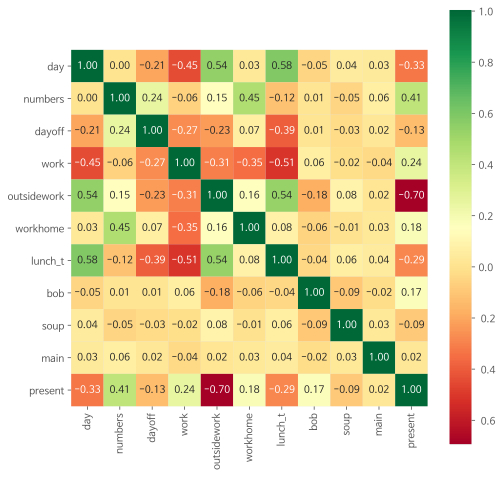

In [106]:
plt.figure(figsize=(8,8))
sns.heatmap(train.corr(), square=True, annot=True, fmt='.2f', cmap='RdYlGn')